## Example 3: Hand-Eye Calibration

In [1]:
import os
import json

import cv2
import numpy as np
import sophus as sp

import fairotag as frt

DATA_DIR = "data/2_hand_eye_calibration"

NUM_CAMERAS = 3
NUM_SAMPLES = 12

# (id, length)
TABLE_MARKER = (0, 0.1)
EE_MARKER = (8, 0.04)

Instantiate camera modules

In [2]:
with open("data/realsense_intrinsics.json", 'r') as f:
    intrinsics = json.load(f)

camera_modules = []
for _ in range(NUM_CAMERAS):
    c = frt.CameraModule()
    c.set_intrinsics(frt.utils.dict2intrinsics(intrinsics))
    camera_modules.append(c)

Instantiate scene

In [3]:
scene = frt.Scene()

scene.add_frame("ee")
for i, c in enumerate(camera_modules):
    scene.add_camera(f"camera_{i + 1}")

Register markers: In this example we assume there is a marker attached to the static workspace and a marker attached to the end-effector.

In [4]:
# Register markers in cameras
for c in camera_modules:
    for marker in [TABLE_MARKER, EE_MARKER]:
        c.register_marker_size(marker[0], marker[1])

# Register markers in scene
scene.add_marker(TABLE_MARKER[0], length=TABLE_MARKER[1])
scene.add_marker(EE_MARKER[0], length=EE_MARKER[1], frame="ee")

Load calibration data

`ee_poses.npz` contains a dictionary with fields "pos" and "quat", each containing a matrix where the j th row is the position or quaternion of the end-effector in that sample.

`camera<i>_<j>.jpg` contains the image taken from the i th camera at the j th sample.

In [5]:
# Load EE pose data
ee_pose_data = np.load(os.path.join(DATA_DIR, "ee_poses.npz"))

# Load images
imgs_data = []
for j in range(NUM_SAMPLES):
    imgs = []
    for i in range(NUM_CAMERAS):
        filename = os.path.join(DATA_DIR, f"camera{i}_{j}.jpg")
        img = cv2.imread(filename)
        imgs.append(img)
    
    imgs_data.append(imgs)

Add snapshots to scene & solve for extrinsics

Note: The optimization process begins by using BFS to initialize all nodes within the factor graph. `init_node` specifies which node to start the BFS from. `init_node` can be any camera, marker, or frame, and defaults to the world frame if not specified. In this particular set of the hand-eye calibration problem, the world frame (which is the robot base) is not a good initialization point, and thus only by specifying the table marker as the initialization node can the optimization problem work.

In [9]:
# Add snapshots
for j in range(NUM_SAMPLES):
    # Extract sampled EE pose 
    ee_pos = ee_pose_data["pos"][j, :]
    ee_quat = ee_pose_data["quat"][j, :]
    ee_pose = frt.utils.xyz_quat_to_se3(ee_pos, ee_quat)

    # Extract sampled images
    imgs = imgs_data[j]
    marker_obs = [c.detect_markers(img) for c, img in zip(camera_modules, imgs)]

    # Add snapshot
    scene.add_snapshot(
        detected_markers={f"camera_{i + 1}": detected_markers for i, detected_markers in enumerate(marker_obs)},
        frame_transforms=[("world", "ee", ee_pose)],
    )

# Calibrate extrinsics
scene.calibrate_extrinsics(init_node=f"o__{TABLE_MARKER[0]}", verbosity=1)

converged
errorThreshold: 3729.3491153 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 1 >? 100


Query & vizualize results

{'name': 'camera_1', 'frame': 'world', 'pose': SE3([[    0.97279618485283,    0.231578401520628, -0.00624713413724087,  -0.0359100208981093],
     [  0.0149721764998872,  -0.0359380590065024,     0.99924185753285,    -1.02733615380064],
     [   0.231178322224714,   -0.972152199948133,    -0.03842763939367,    0.278449820179892],
     [                   0,                    0,                    0,                    1]]), 'pose_in_frame': SE3([[  0.968094322369232,   0.176045045851984,   0.178329820353835,  -0.185405324938858],
     [ -0.171095815427557, -0.0555745215161583,   0.983685770203793,   -1.09336370779651],
     [  0.183083600957697,  -0.982812095158186, -0.0236808080761526,   0.266111203808355],
     [                  0,                   0,                   0,                   1]]), 'is_anchor': False}
{'name': 'camera_2', 'frame': 'world', 'pose': SE3([[ 0.408283202364039,  0.677928476173876, -0.611324633774831,  0.475392645065129],
     [ 0.819636903622414, 0.022571

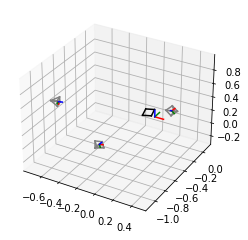

In [10]:
for i in range(NUM_CAMERAS):
    print(scene.get_camera_info(f"camera_{i + 1}"))

scene.visualize()

In [11]:
scene.get_marker_info(TABLE_MARKER[0])

{'id': 0,
 'frame': 'world',
 'pose': SE3([[  0.971490635580369,  -0.150971442272957,  -0.182793787087179, -0.0799016925564323],
      [ 0.0860675323225513,    0.94301538004757,  -0.321425532392254,  0.0139015747986368],
      [  0.220903428808963,   0.296529284577022,   0.929124350412087,  0.0290204801977228],
      [                  0,                   0,                   0,                   1]]),
 'pose_in_frame': SE3([[  0.971495804701087,  -0.151078341420603,  -0.182677957624303, -0.0799034052383996],
      [ 0.0862017206599869,   0.942995294951479,  -0.321448498292697,  0.0139463534954767],
      [  0.220828360505268,   0.296538713244953,   0.929139185883139,  0.0290658179824247],
      [                  0,                   0,                   0,                   1]]),
 'length': 0.1,
 'is_anchor': False,
 'is_visible': True}